In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several 
#helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'train.csv', 'test.csv']


In [2]:
from matplotlib import pyplot as plt
from math import floor
import seaborn as sns
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from keras.layers import Input,Conv2D,Dense, Dropout, BatchNormalization, MaxPooling2D, Activation, Flatten, AvgPool2D
from keras.layers import  BatchNormalization as btn
from keras.models import Model, Sequential
from keras.applications.resnet50 import ResNet50
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras.callbacks import LearningRateScheduler
from IPython.display import HTML
import base64
from scipy.ndimage.interpolation import shift
from keras.optimizers import Adam
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

Using TensorFlow backend.


### GETTING DATA

In [3]:
train_csv = pd.read_csv('../input/train.csv')
test_csv = pd.read_csv('../input/test.csv')

### UNDERSTANDING DATA

In [4]:
train_csv.head()

label  pixel0  pixel1    ...     pixel781  pixel782  pixel783
0      1       0       0    ...            0         0         0
1      0       0       0    ...            0         0         0
2      1       0       0    ...            0         0         0
3      4       0       0    ...            0         0         0
4      0       0       0    ...            0         0         0

[5 rows x 785 columns]

In [5]:
train_csv.shape,test_csv.shape

((42000, 785), (28000, 784))

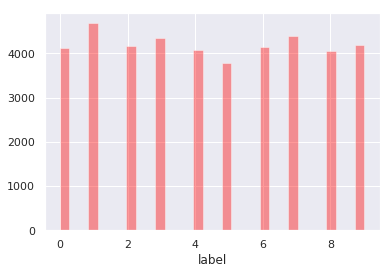

In [6]:
### CHECKING DISTRIBUTION OF DATASET
sns.set(color_codes=True)
sns.distplot(train_csv.iloc[:,0],label = 'LABELS',kde=False
             ,color='red',norm_hist=False,rug=False);

### PLOTING IMAGES

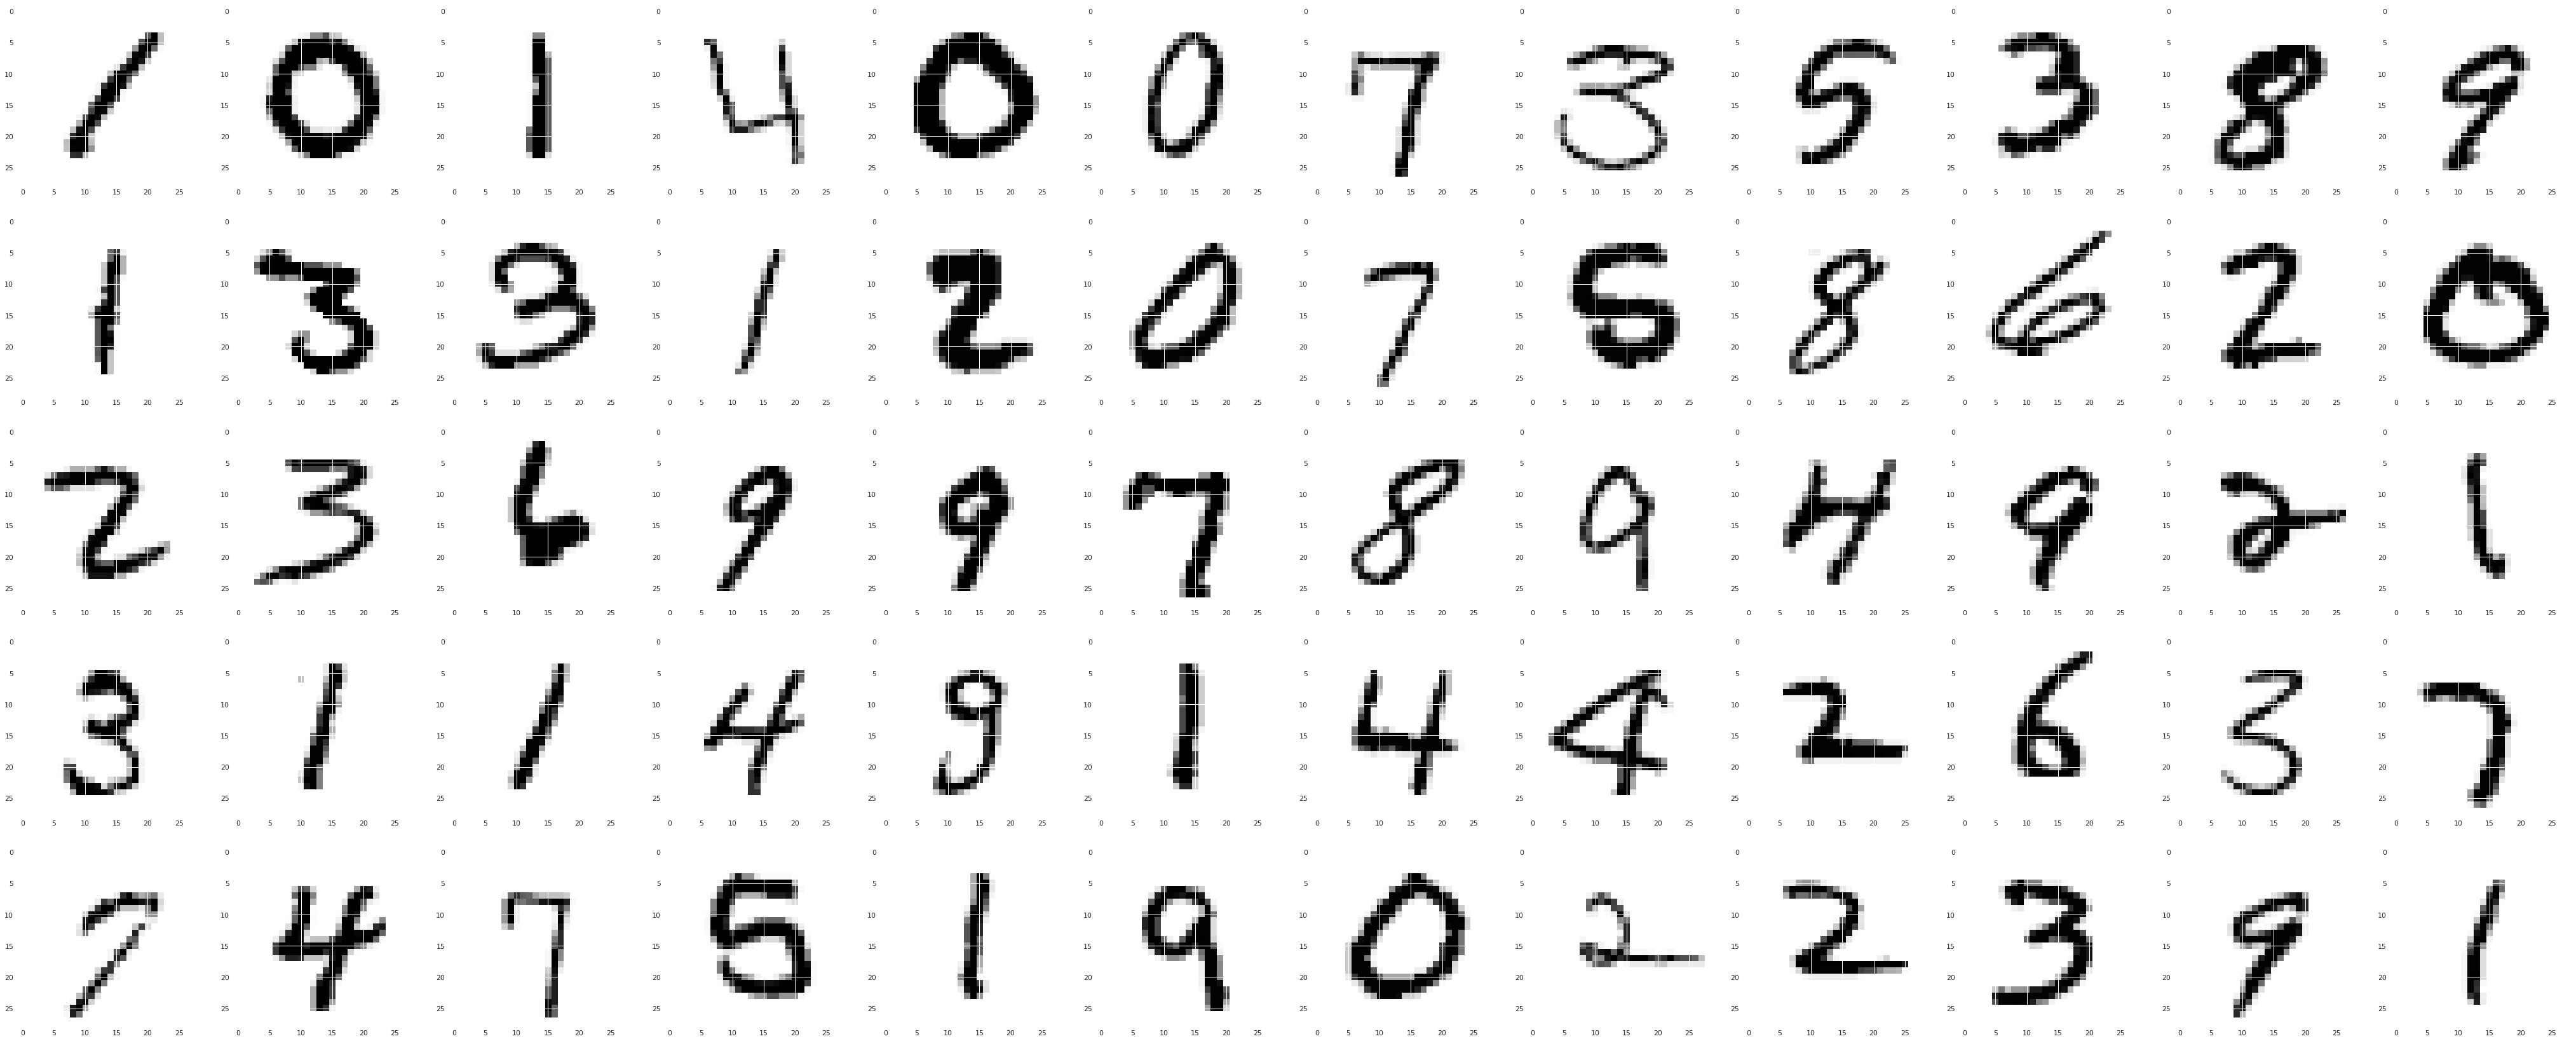

In [7]:
size_of_img = (int(np.sqrt(train_csv.shape[1])),int(np.sqrt(train_csv.shape[1])))
fig=plt.figure(figsize=(72,72))
for i in range(60):
    ax=fig.add_subplot(12,12,i+1)
    plot_image = np.array(train_csv.iloc[i,1:]).reshape(size_of_img)
    ax.imshow(plot_image,cmap='Greys')
plt.show()

### DATA PREPROCESSING

In [8]:
def dataset_distribution(train,distribution = [60,20,20]):
    # dividing dataset in TRAIN, DEV, TEST
    # distribution is an array which tell divide percentage
    train = np.array(train)
    np.random.shuffle(train)
    perc_train = floor(distribution[0] * 0.01*train.shape[0])
    perc_dev = perc_train + floor(distribution[1] * 0.01*train.shape[0])
    perc_test = perc_dev + floor(distribution[2] * 0.01*train.shape[0])
    train_feature = train[0:perc_train,1:]
    train_label =  train[0:perc_train,0]
    
    dev_feature = train[perc_train:perc_dev,1:]
    dev_label =  train[perc_train:perc_dev,0]
    
    test_feature = train[perc_dev:perc_test,1:]
    test_label =  train[perc_dev:perc_test,0]
    
    return train_feature/255, train_label, dev_feature/255, dev_label, test_feature/255, test_label

In [9]:
def one_hot_encoding(label):
    ### ONE HOT ENCODING OF LABEL
    no_of_class = np.unique(label).shape[0]
    enc_labels = np.zeros((label.shape[0],no_of_class))
    for index in range(label.shape[0]):
        enc_labels[index,label[index]] = 1
    return enc_labels

In [10]:
def de_encoding(prediction):
    ### DE CODING LABEL
    predict = np.zeros((prediction.shape[0]))
    for index in range(prediction.shape[0]):
        predict[index] = np.argmax(prediction[index])
    return predict

In [11]:
def change_to_image(in_feature):
    ### CHANGING ARRAY TO IMAGE
    ### RESHAPING ARRAY FROM (,784) TO (1,28,28,1)
    feature = np.zeros(shape = (in_feature.shape[0],size_of_img[0],size_of_img[1], 1))
    for image_index in range(in_feature.shape[0]):
        feature[image_index] = (in_feature[image_index]).reshape(size_of_img[0],size_of_img[1], 1)
    return feature

In [12]:

def create_download_link(df, title = "Download CSV file", filename = "data.csv"): 
    ### CREATING CSV FILE
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [13]:
def acc(y_test,prediction):

    ### PRINTING ACCURACY OF PREDICTION
    ### RECALL
    ### PRECISION
    ### CLASIFICATION REPORT
    ### CONFUSION MATRIX
    cm = confusion_matrix(y_test, prediction)
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    
    print ('Recall:', recall)
    print ('Precision:', precision)
    print ('\n clasification report:\n', classification_report(y_test,prediction))
    print ('\n confussion matrix:\n',confusion_matrix(y_test, prediction))
    
    ax = sns.heatmap(confusion_matrix(y_test, prediction),linewidths= 0.5,cmap="YlGnBu")

In [14]:
train_feature, train_labels, dev_feature, dev_labels,_,__ = dataset_distribution(train_csv,[80,20,0])
train_feature.shape, train_labels.shape, dev_feature.shape, dev_labels.shape

((33600, 784), (33600,), (8400, 784), (8400,))

In [15]:
train_image = change_to_image(train_feature)
dev_image     = change_to_image(dev_feature)

In [16]:
train_label = one_hot_encoding(train_labels)
dev_label = one_hot_encoding(dev_labels)

In [17]:
no_of_class  = 10
no_of_class,train_image.shape,dev_image.shape

(10, (33600, 28, 28, 1), (8400, 28, 28, 1))

In [18]:
perc = 85
#no_of_image_in_train = floor(train_csv.shape[0]*perc*0.01)
no_of_class = 10
print("no_of_class : ",no_of_class)
print("train_image.shape : ",train_image.shape)
print("dev_image.shape : ",dev_image.shape)
print("train_label.shape : ",train_label.shape)
print("dev_label.shape: ",dev_label.shape)
print("train_feature: ",train_feature.shape)
print("train_labels.shape : ",train_labels.shape)


no_of_class :  10
train_image.shape :  (33600, 28, 28, 1)
dev_image.shape :  (8400, 28, 28, 1)
train_label.shape :  (33600, 10)
dev_label.shape:  (8400, 10)
train_feature:  (33600, 784)
train_labels.shape :  (33600,)


### DATA AUGMENTATION

In [19]:
gen = ImageDataGenerator(
        rotation_range=3,  
        zoom_range = 0.070,  
        width_shift_range=0.01, 
        height_shift_range=0.01)


### MODEL

In [20]:

model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.44))

model.add(Conv2D(256, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.65))
model.add(Dense(10, activation='softmax'))


# COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
__________

In [22]:
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# TRAIN NETWORKS
epochs = 13
X_train2, X_val2, Y_train2, Y_val2 = train_image,dev_image, train_label, dev_label
history = model.fit_generator(gen.flow(X_train2,Y_train2, batch_size=100),
    epochs = epochs, steps_per_epoch = X_train2.shape[0]//100,  
    validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=2)


Epoch 1/13
 - 13s - loss: 0.4045 - acc: 0.8838 - val_loss: 0.0688 - val_acc: 0.9783
Epoch 2/13
 - 8s - loss: 0.1092 - acc: 0.9659 - val_loss: 0.0434 - val_acc: 0.9868
Epoch 3/13
 - 9s - loss: 0.0817 - acc: 0.9746 - val_loss: 0.0416 - val_acc: 0.9871
Epoch 4/13
 - 9s - loss: 0.0639 - acc: 0.9806 - val_loss: 0.0385 - val_acc: 0.9895
Epoch 5/13
 - 9s - loss: 0.0560 - acc: 0.9829 - val_loss: 0.0307 - val_acc: 0.9913
Epoch 6/13
 - 9s - loss: 0.0479 - acc: 0.9854 - val_loss: 0.0255 - val_acc: 0.9918
Epoch 7/13
 - 8s - loss: 0.0440 - acc: 0.9866 - val_loss: 0.0293 - val_acc: 0.9925
Epoch 8/13
 - 9s - loss: 0.0443 - acc: 0.9865 - val_loss: 0.0268 - val_acc: 0.9919
Epoch 9/13
 - 9s - loss: 0.0359 - acc: 0.9890 - val_loss: 0.0326 - val_acc: 0.9910
Epoch 10/13
 - 8s - loss: 0.0373 - acc: 0.9882 - val_loss: 0.0239 - val_acc: 0.9929
Epoch 11/13
 - 8s - loss: 0.0334 - acc: 0.9904 - val_loss: 0.0237 - val_acc: 0.9933
Epoch 12/13
 - 9s - loss: 0.0299 - acc: 0.9911 - val_loss: 0.0266 - val_acc: 0.9926


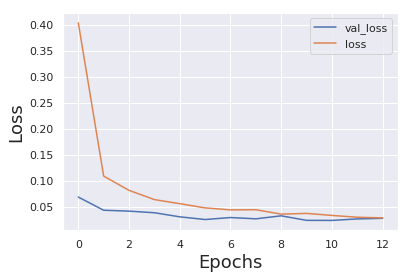

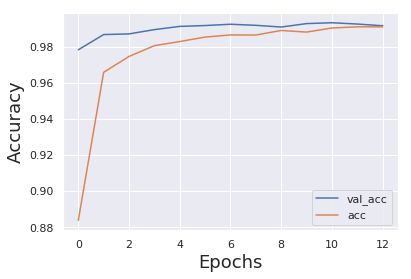

In [23]:
name_title = ['Loss','Accuracy']
for i in range(0,2):
    ax=fig.add_subplot(8,8,i+1)
    plt.plot(history.history[list(history.history.keys())[i]], label = list(history.history.keys())[i] )
    plt.plot(history.history[list(history.history.keys())[i+2]],label = list(history.history.keys())[i+2] )
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel(name_title[i], fontsize=18)
    plt.legend()
    plt.show()

Recall: [0.99258344 0.99363733 0.99141104 0.99135135 0.99637243 0.99081365
 0.99366286 0.98716453 0.99288256 0.98674699]
Precision: [0.99381188 0.9957492  0.99141104 0.99565689 0.98329356 0.99342105
 0.98989899 0.99412456 0.99170616 0.98674699]

 clasification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       809
           1       1.00      0.99      0.99       943
           2       0.99      0.99      0.99       815
           3       1.00      0.99      0.99       925
           4       0.98      1.00      0.99       827
           5       0.99      0.99      0.99       762
           6       0.99      0.99      0.99       789
           7       0.99      0.99      0.99       857
           8       0.99      0.99      0.99       843
           9       0.99      0.99      0.99       830

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99   

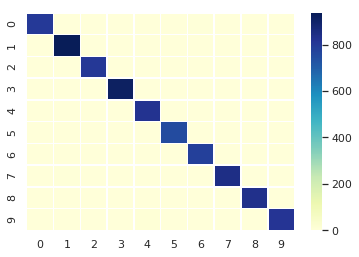

In [24]:
X_test = dev_image
cnn_pred = model.predict_proba(change_to_image(np.array(test_csv)/255))
results = model.predict(X_test)
results = np.argmax(results,axis = 1)
acc(dev_labels,results)

In [25]:
create_download_link(pd.DataFrame(cnn_pred))